In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
# client = bigquery.Client(project="ambient-sylph-426620-g6") # Odele

client = bigquery.Client(project="pacific-booking-438707-k1")

In [2]:
query = '''
    WITH purchases as(
        SELECT distinct
            fullVisitorId as user_id
            ,PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) AS datetime
            ,product.productSKU AS product_id
            ,product.v2ProductName AS product_name
            ,product.v2ProductCategory AS product_category
            ,product.productPrice/1000000 AS product_price
            ,product.productQuantity AS product_qty
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        LEFT JOIN UNNEST(hits.product) AS product ON TRUE
        WHERE true
            and hits.eCommerceAction.action_type  = '6'
            and product.productQuantity > 0
            and PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) < date '2017-08-01'
    )
    SELECT 
        date_trunc(datetime, day) as ymd
        ,product_id
        ,product_name
        ,product_category product_category_temp
        ,product_price
        ,sum(product_qty) as daily_qty
        ,count(distinct user_id) as daily_user_cnt
    FROM purchases
    GROUP BY 2,1,3,4,5
    ORDER BY 1,2,3
    
'''

rows = client.query(query)
daily_sales = rows.to_dataframe()
raw_ga_data = rows.to_dataframe()

## 1. Querying product sales from GA

In [3]:
daily_sales["ymd"] = pd.to_datetime(daily_sales["ymd"])
daily_sales.replace('(not set)', np.nan, inplace = True)
daily_sales['product_category_temp'].replace('${productitem.product.origCatName}', np.nan, inplace = True)
daily_sales['product_category_temp'].replace(['Tumblers', 'Bottles', 'Google'], 'Drinkware', inplace = True)
daily_sales['product_category_temp'].replace(['More Bags', 'Backpacks'], 'Bags', inplace = True)
daily_sales['product_category_temp'].replace('Android', 'Apparel', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"Waze.*(Men's|Women's|Socks)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales['product_category_temp'].replace('Waze', 'Office', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"(Shirt|Sleeve|Tee|Jacket|Pullover|Hoodie|Tank|Vest|Onesie|Pants|Hood|Polo)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales.loc[daily_sales["product_name"].str.contains(r"(oz|Bottle|Cup)", case = True, na = False), "product_category_temp"] = "Drinkware"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Journal|Notebook", case = True, na = False), "product_category_temp"] = "Notebooks & Journals"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Bag|Backpack|Tote|Rucksack", case = True, na = False), "product_category_temp"] = "Bags"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Gift Card", case = True, na = False), "v"] = "Gift Cards"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Electronics|Device|Headphones|Earbuds|Earphones", case = True, na = False), "product_category_temp"] = "Electronics"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Cap|Hat", case = True, na = False), "product_category_temp"] = "Headgear"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Pen", case = True, na = False), "product_category_temp"] = "Office"
daily_sales["product_id"] = daily_sales['product_id'].astype("string")
product_category_mode = daily_sales.groupby(["product_id", "product_price"])["product_category_temp"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name="product_category")
daily_sales = daily_sales.merge(product_category_mode, on = ["product_id", "product_price"], how = "left")
daily_sales = daily_sales.groupby(["ymd", "product_id", "product_price", "product_category"])[["daily_qty", "daily_user_cnt"]].sum().reset_index()

daily_sales.dropna(subset = ['product_category'], inplace = True)

## 2. Grouping by product category and date to get sales per day

In [4]:
# Grouping the sales data by product category and date
category_sales = daily_sales.groupby(['ymd', 'product_category']).agg(
    daily_qty_sum=('daily_qty', 'sum'),  # Sum of quantities sold per day
    avg_price=('product_price', 'mean')  # Average price per day
).reset_index()

# Displaying the first few rows
category_sales.head()


,ymd,product_category,daily_qty_sum,avg_price
0,2016-08-01,Accessories,1,4.990000
1,2016-08-01,Apparel,67,18.730741
2,2016-08-01,Bags,15,34.590000
3,2016-08-01,Drinkware,235,8.943529
4,2016-08-01,Electronics,73,17.841667


## 3. Calculating price and quantity change

In [5]:
# Calculating the percentage change in daily quantity sold and average price for each category
category_sales['pct_change_qty'] = category_sales.groupby('product_category')['daily_qty_sum'].pct_change()
category_sales['pct_change_price'] = category_sales.groupby('product_category')['avg_price'].pct_change()

# Dropping rows with NaN values that result from the first day in each category (no previous day to compare)
category_sales.dropna(subset=['pct_change_qty', 'pct_change_price'], inplace=True)

# Displaying the data with percentage changes
category_sales.head()


,ymd,product_category,daily_qty_sum,avg_price,pct_change_qty,pct_change_price
9,2016-08-02,Apparel,21,19.478889,-0.686567,0.039942
10,2016-08-02,Bags,4,20.926667,-0.733333,-0.395008
11,2016-08-02,Drinkware,178,4.490000,-0.242553,-0.497961
12,2016-08-02,Electronics,14,2.595000,-0.808219,-0.854554
15,2016-08-02,Lifestyle,49,2.398571,-0.234375,-0.252146


## 4. Calculating price elasticity

In [6]:
# Calculating price elasticity for each product category
category_sales['price_elasticity'] = category_sales['pct_change_qty'] / category_sales['pct_change_price']

# Display the data with elasticity values
category_sales.head()

,ymd,product_category,daily_qty_sum,avg_price,pct_change_qty,pct_change_price,price_elasticity
9,2016-08-02,Apparel,21,19.478889,-0.686567,0.039942,-17.188991
10,2016-08-02,Bags,4,20.926667,-0.733333,-0.395008,1.856502
11,2016-08-02,Drinkware,178,4.490000,-0.242553,-0.497961,0.487093
12,2016-08-02,Electronics,14,2.595000,-0.808219,-0.854554,0.945779
15,2016-08-02,Lifestyle,49,2.398571,-0.234375,-0.252146,0.929521


## 5. Removing infinity values

In [7]:
# Step 1: Remove rows where 'price_elasticity' has infinite values
category_sales_clean = category_sales[~np.isinf(category_sales['price_elasticity'])]

# Step 2: Display the cleaned data
category_sales_clean.head()

,ymd,product_category,daily_qty_sum,avg_price,pct_change_qty,pct_change_price,price_elasticity
9,2016-08-02,Apparel,21,19.478889,-0.686567,0.039942,-17.188991
10,2016-08-02,Bags,4,20.926667,-0.733333,-0.395008,1.856502
11,2016-08-02,Drinkware,178,4.490000,-0.242553,-0.497961,0.487093
12,2016-08-02,Electronics,14,2.595000,-0.808219,-0.854554,0.945779
15,2016-08-02,Lifestyle,49,2.398571,-0.234375,-0.252146,0.929521


## 6. Calculating Sum and Mean Price Elasticity for each Month

In [28]:
# Step 1: Convert the 'ymd' column to a monthly period (if not already in datetime format)
category_sales['ymd'] = pd.to_datetime(category_sales['ymd'])  # Ensure it's a datetime object
category_sales['month'] = category_sales['ymd'].dt.to_period('M')  # Converts date to 'YYYY-MM'

# Step 2: Group by 'month' and 'product_category', and calculate sum and mean of 'price_elasticity', 
# sum of 'daily_qty_sum', and both sum and mean of 'avg_price'
monthly_elasticity_summary = category_sales.groupby(['month', 'product_category']).agg(
    mean_price_elasticity=('price_elasticity', 'mean'),  # Mean of price elasticity for each month and category
    mean_price=('avg_price', 'mean')  # Mean of prices for each month
).reset_index()

# Step 3: Display the result
print(monthly_elasticity_summary)

       month      product_category  mean_price_elasticity  mean_price
0    2016-08           Accessories                    NaN    4.365000
1    2016-08               Apparel              74.736859   23.634966
2    2016-08                  Bags              27.972884   30.540105
3    2016-08             Drinkware              40.912189    9.194837
4    2016-08           Electronics              -0.236992   19.452514
..       ...                   ...                    ...         ...
135  2017-07              Headgear                    NaN   12.378185
136  2017-07            Housewares                    NaN    1.677778
137  2017-07             Lifestyle               1.228165    4.721422
138  2017-07  Notebooks & Journals              -49.05597    8.969173
139  2017-07                Office               20.81582    3.436271

[140 rows x 4 columns]


## 7. Cleaning price elasticity values

In [32]:
# Step 1: Remove rows where 'mean_price' or 'sum_price' have NaN or infinite values
monthly_elasticity_summary_clean = monthly_elasticity_summary.dropna(subset=['mean_price'])
monthly_elasticity_summary_clean = monthly_elasticity_summary_clean[~np.isinf(monthly_elasticity_summary_clean[['mean_price']].values).any(axis=1)]

# Step 2: Convert 'mean_price' and 'sum_price' to numeric, coercing any errors (in case of unexpected values)
monthly_elasticity_summary_clean['mean_price'] = pd.to_numeric(monthly_elasticity_summary_clean['mean_price'], errors='coerce')
# Step 3: Handle NaN values: either drop or fill them. In this case, we will drop them
monthly_elasticity_summary_clean = monthly_elasticity_summary_clean.replace([np.inf, -np.inf], np.nan).dropna()

# Step 5: Clean 'mean_price_elasticity' to ensure there are no NaN or infinite values
monthly_elasticity_summary_clean['mean_price_elasticity'] = pd.to_numeric(monthly_elasticity_summary_clean['mean_price_elasticity'], errors='coerce')
monthly_elasticity_summary_clean = monthly_elasticity_summary_clean.dropna(subset=['mean_price_elasticity'])

# Step 6: Display the cleaned data
print(monthly_elasticity_summary_clean)

       month      product_category  mean_price_elasticity  mean_price
0    2016-08           Accessories                    NaN    4.365000
1    2016-08               Apparel              74.736859   23.634966
2    2016-08                  Bags              27.972884   30.540105
3    2016-08             Drinkware              40.912189    9.194837
4    2016-08           Electronics              -0.236992   19.452514
..       ...                   ...                    ...         ...
135  2017-07              Headgear                    NaN   12.378185
136  2017-07            Housewares                    NaN    1.677778
137  2017-07             Lifestyle               1.228165    4.721422
138  2017-07  Notebooks & Journals              -49.05597    8.969173
139  2017-07                Office               20.81582    3.436271

[129 rows x 4 columns]


## 8. Importing Synthetic Data and Cleaning the Data

In [34]:

# Load the uploaded data
file_path = '/Users/valerielim/Documents/DSA3101-project/E-commerce-Performance-Analysis-and-Optimization/SubgroupB/cleaned_synthetic_v3.csv'
sales_data = pd.read_csv(file_path)

# Rename columns for clarity and compatibility with the script
sales_data.rename(columns={'year_month': 'month', 'present_total_qty': 'sum_qty'}, inplace=True)

# Grouping the sales data by product category and date
synthetic_sales_data = sales_data.groupby(['month', 'product_category']).agg(
    sum_qty=('sum_qty', 'sum'),  # Sum of quantities sold per month
    mean_price=('product_price', 'mean')  # Average price per month
).reset_index()

# Ensure the 'month' column is in datetime format
synthetic_sales_data['month'] = pd.to_datetime(synthetic_sales_data['month'])

# Format the 'month' column to display only 'YYYY-MM'
synthetic_sales_data['month'] = synthetic_sales_data['month'].dt.strftime('%Y-%m')

# Calculate percentage change in quantity and price for each product category
synthetic_sales_data['pct_change_qty'] = synthetic_sales_data.groupby('product_category')['sum_qty'].pct_change()
synthetic_sales_data['pct_change_price'] = synthetic_sales_data.groupby('product_category')['mean_price'].pct_change()

# Calculate price elasticity: % change in quantity / % change in price
synthetic_sales_data['price_elasticity'] = synthetic_sales_data['pct_change_qty'] / synthetic_sales_data['pct_change_price']

# Remove any rows where price elasticity cannot be calculated (infinite or NaN values)
synthetic_sales_data_clean = synthetic_sales_data.replace([np.inf, -np.inf], np.nan).dropna(subset=['price_elasticity'])

# Group the data by month and product category, calculate necessary aggregations
synthetic_monthly_elasticity_summary = synthetic_sales_data_clean.groupby(['month', 'product_category']).agg(
    mean_price_elasticity=('price_elasticity', 'mean'),  # Mean of price elasticity for each month and category
    mean_price=('mean_price', 'mean')  # Mean of prices for each month
).reset_index()

# Rearrange columns and drop unnecessary ones
synthetic_monthly_elasticity_summary = synthetic_monthly_elasticity_summary[['month', 'product_category', 'mean_price_elasticity', 'mean_price']]

synthetic_monthly_elasticity_summary

,month,product_category,mean_price_elasticity,mean_price
0,2016-04,Accessories,2.939971,8.430000
1,2016-04,Apparel,-3.588927,23.892972
2,2016-04,Bags,0.206614,41.604857
3,2016-04,Drinkware,0.555384,11.802075
4,2016-04,Electronics,2.424728,28.293000
5,2016-04,Fun,25.118910,8.390000
6,2016-04,Gift Cards,2.357143,108.333333
7,2016-04,Headgear,-21.103005,17.583714
8,2016-04,Lifestyle,-6.324946,6.914483
9,2016-04,Notebooks & Journals,-2.915815,12.203793


## 9. Combining it with Original Data

In [35]:
# Concatenate the synthetic data (on top) with the original monthly elasticity summary
combined_price_elasticity_data = pd.concat([synthetic_monthly_elasticity_summary, monthly_elasticity_summary_clean], ignore_index=True)

# Convert the 'month' column to the 'YYYY-MM' format
combined_price_elasticity_data['month'] = pd.to_datetime(combined_price_elasticity_data['month']).dt.strftime('%Y-%m')

# Display the updated dataframe
combined_price_elasticity_data

,month,product_category,mean_price_elasticity,mean_price
0,2016-04,Accessories,2.939971,8.430000
1,2016-04,Apparel,-3.588927,23.892972
2,2016-04,Bags,0.206614,41.604857
3,2016-04,Drinkware,0.555384,11.802075
4,2016-04,Electronics,2.424728,28.293000
...,...,...,...,...
167,2017-07,Headgear,NaN,12.378185
168,2017-07,Housewares,NaN,1.677778
169,2017-07,Lifestyle,1.228165,4.721422
170,2017-07,Notebooks & Journals,-49.05597,8.969173


## 9. Plotting time series of price elasticity for each product category

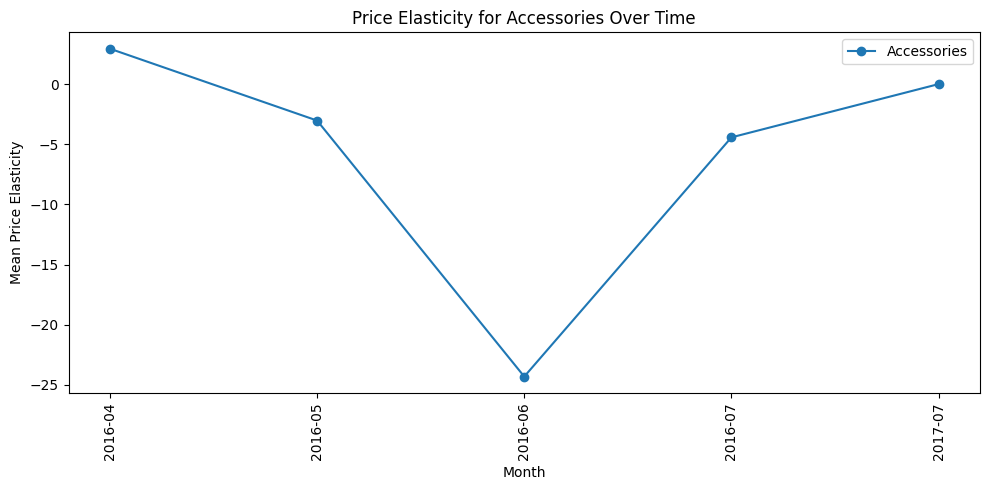

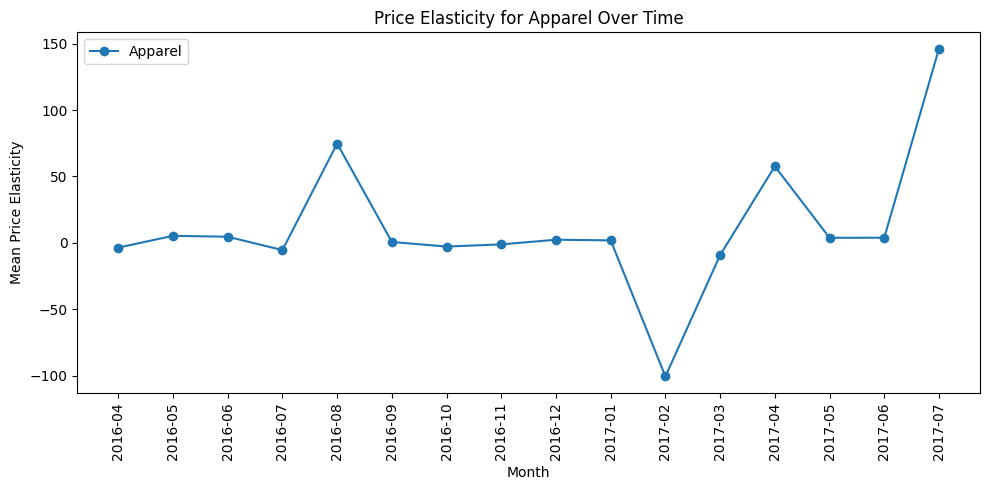

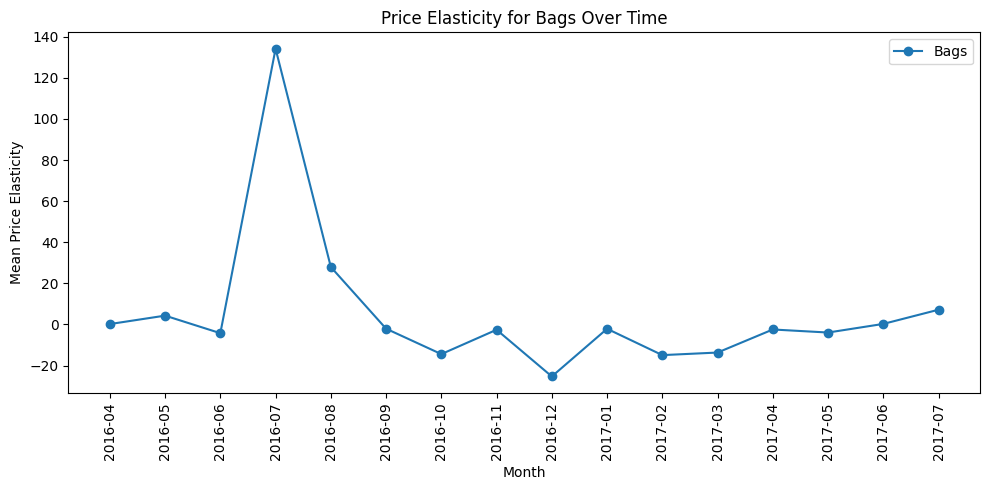

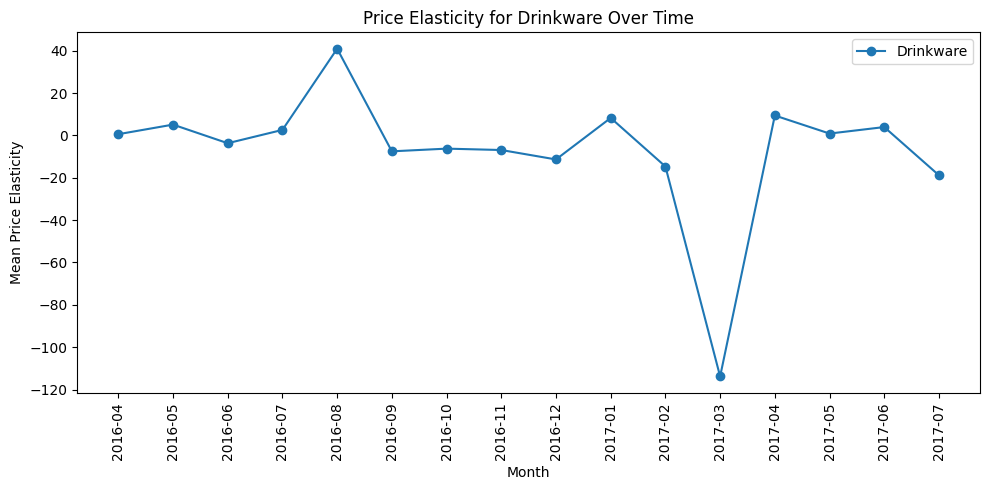

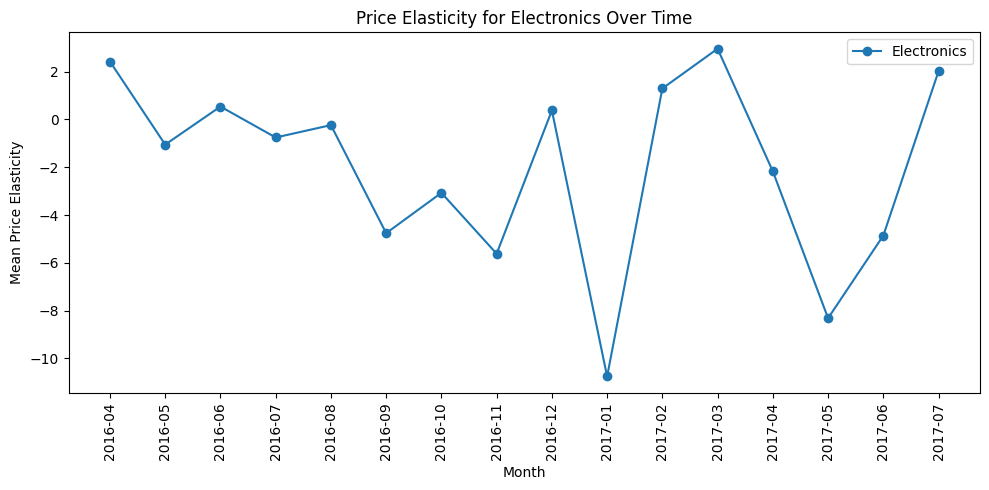

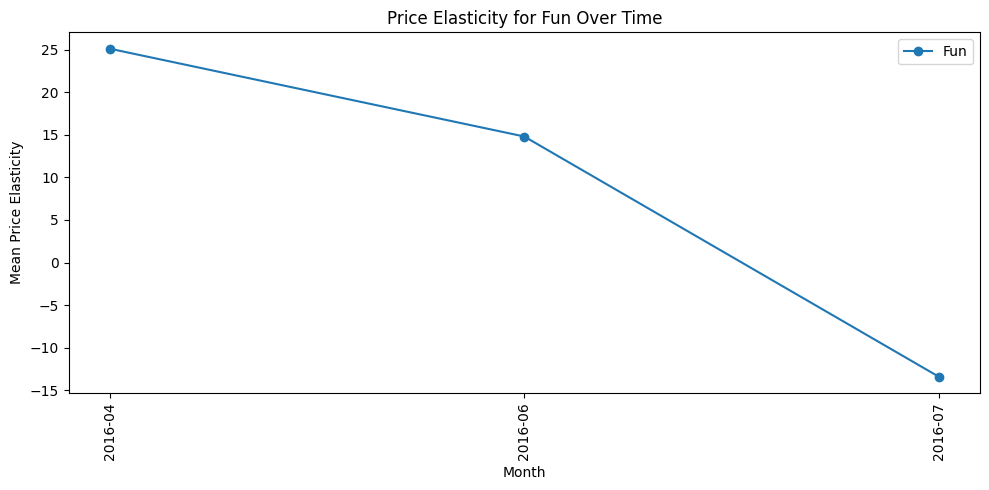

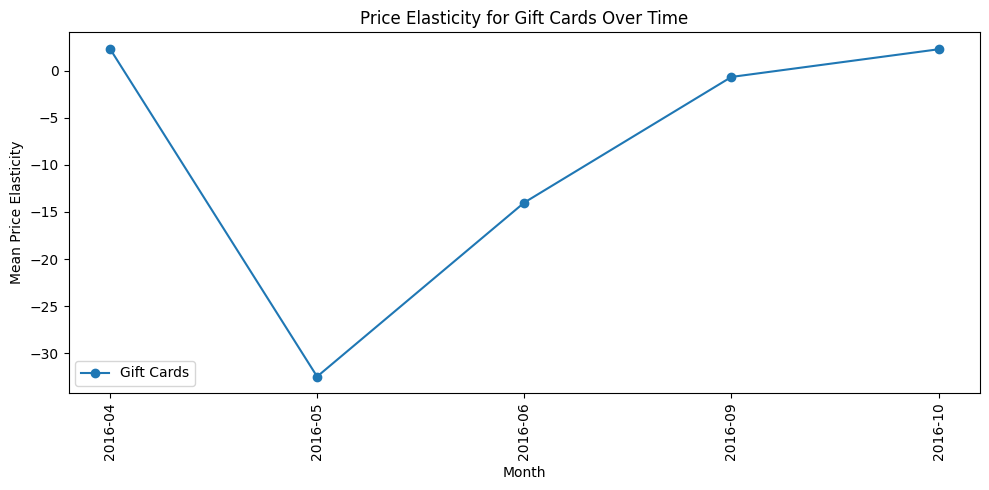

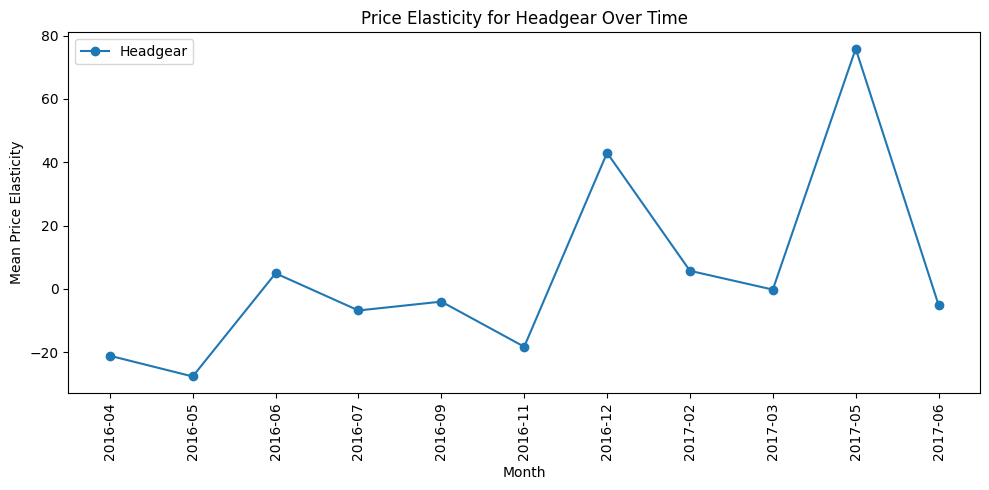

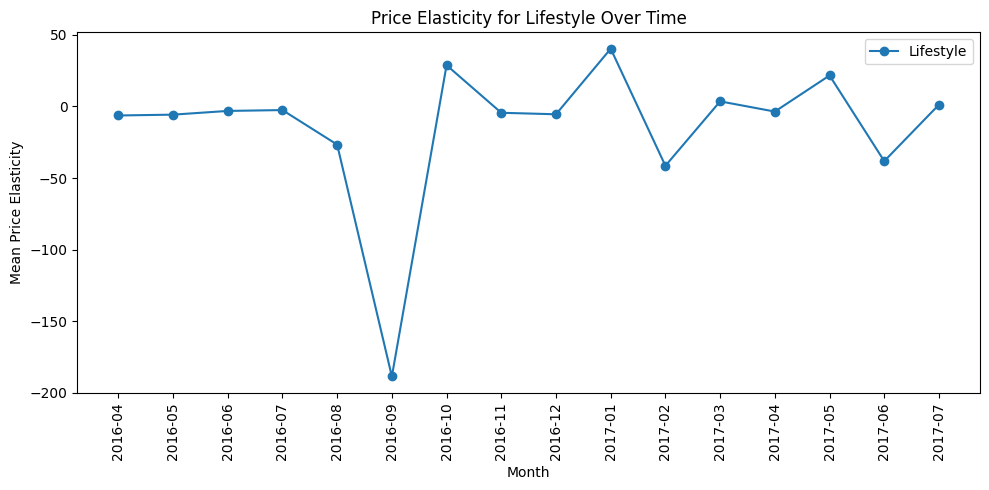

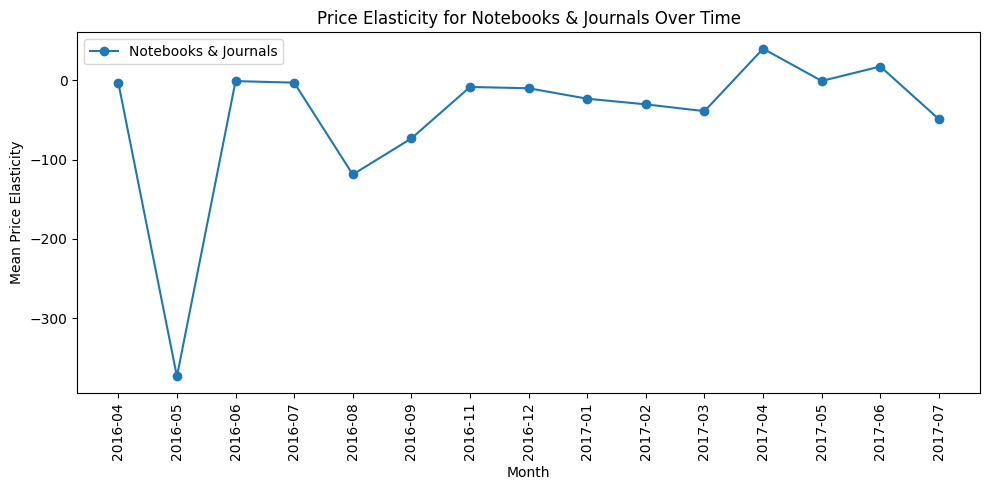

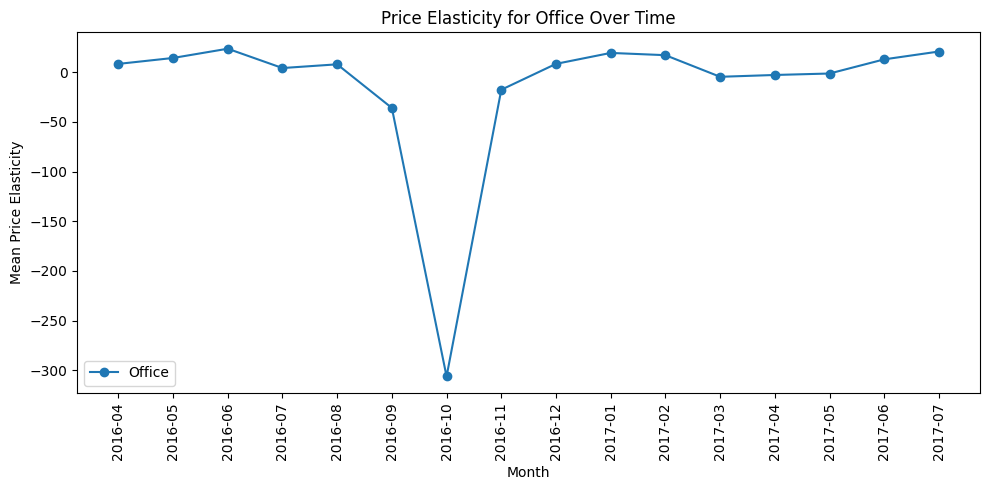

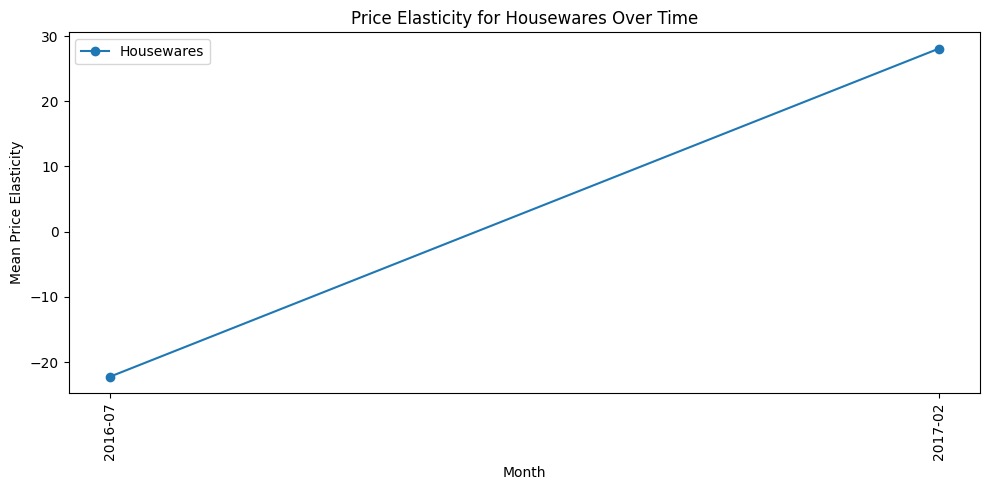

In [36]:
# Load the data
file_path = '/Users/valerielim/Documents/DSA3101-project/E-commerce-Performance-Analysis-and-Optimization/SubgroupB/price modelling/combined_price_elasticity_data.csv'
df = pd.read_csv(file_path)

# Drop any NaN values to ensure clean data
df_clean = df.dropna(subset=['mean_price_elasticity'])

# Loop through each product category and plot individually
for category in df_clean['product_category'].unique():
    category_data = df_clean[df_clean['product_category'] == category]
    
    # Create a new figure for each product category
    plt.figure(figsize=(10, 5))
    
    # Plot the price elasticity for the category
    plt.plot(category_data['month'], category_data['mean_price_elasticity'], marker='o', label=category)
    
    # Add labels and title
    plt.xlabel('Month')
    plt.ylabel('Mean Price Elasticity')
    plt.title(f'Price Elasticity for {category} Over Time')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()


## 10. Creating smoother plots

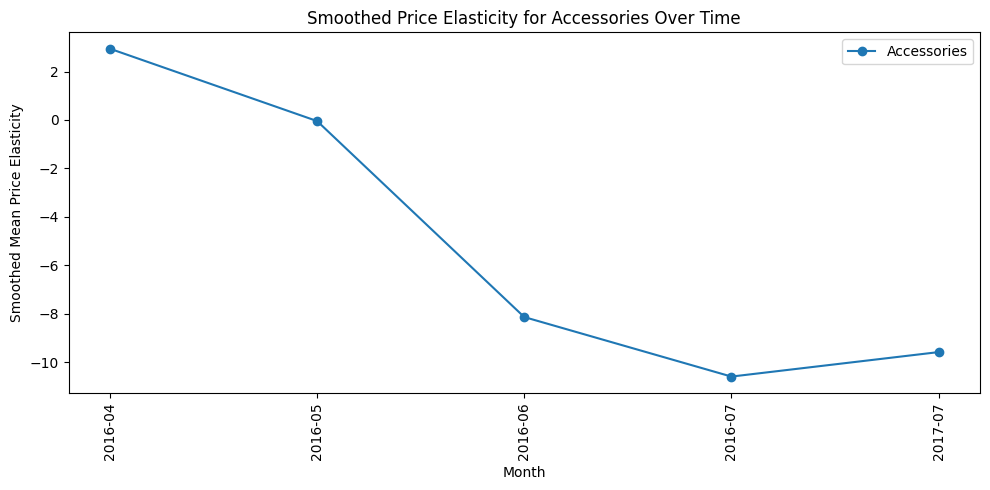

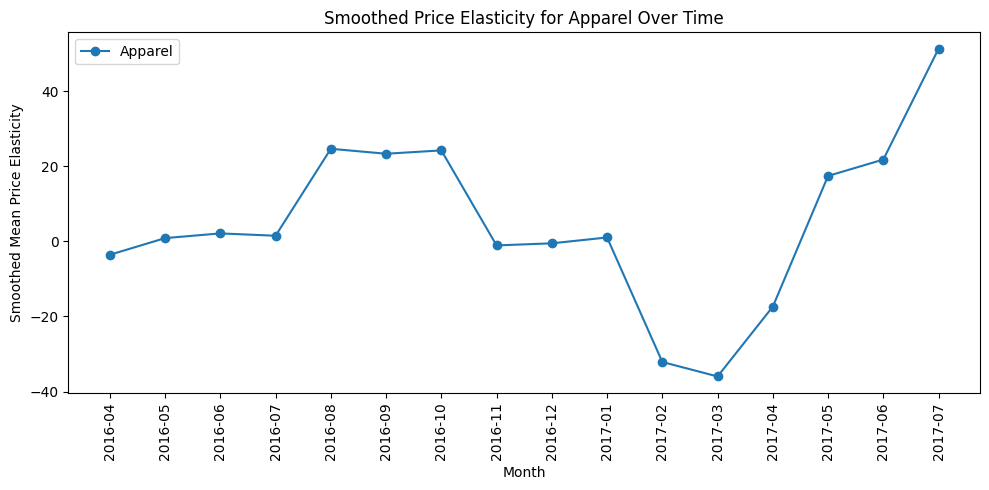

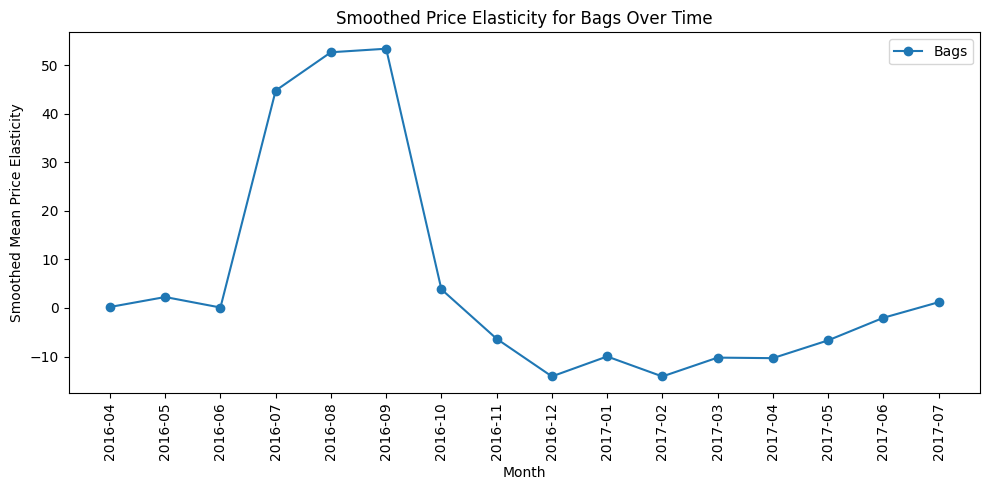

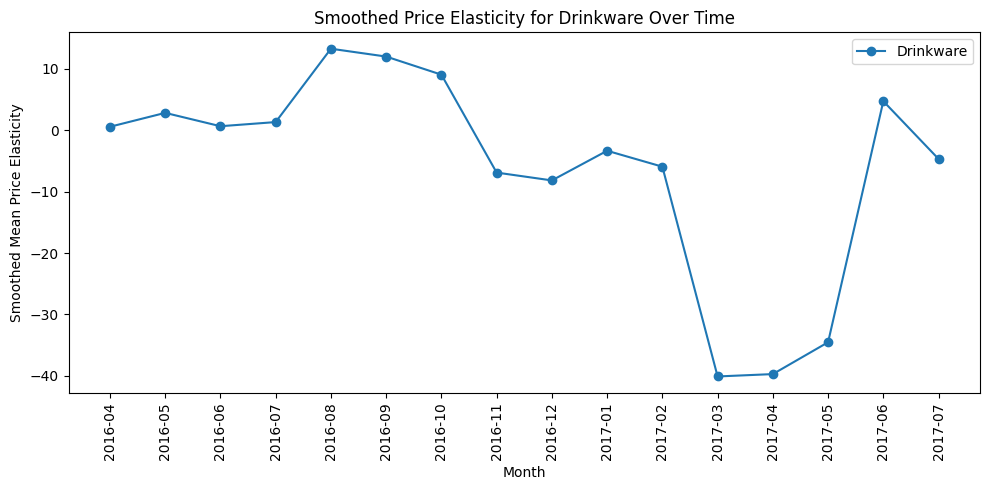

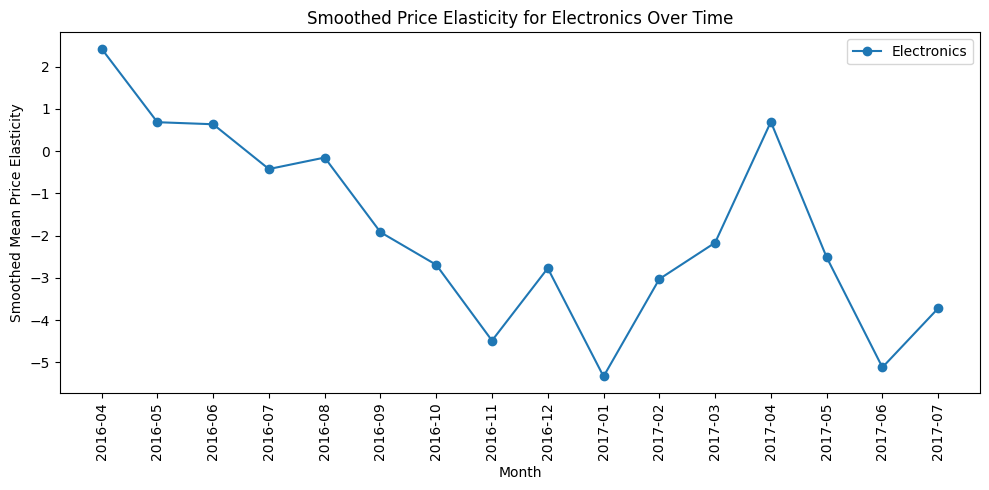

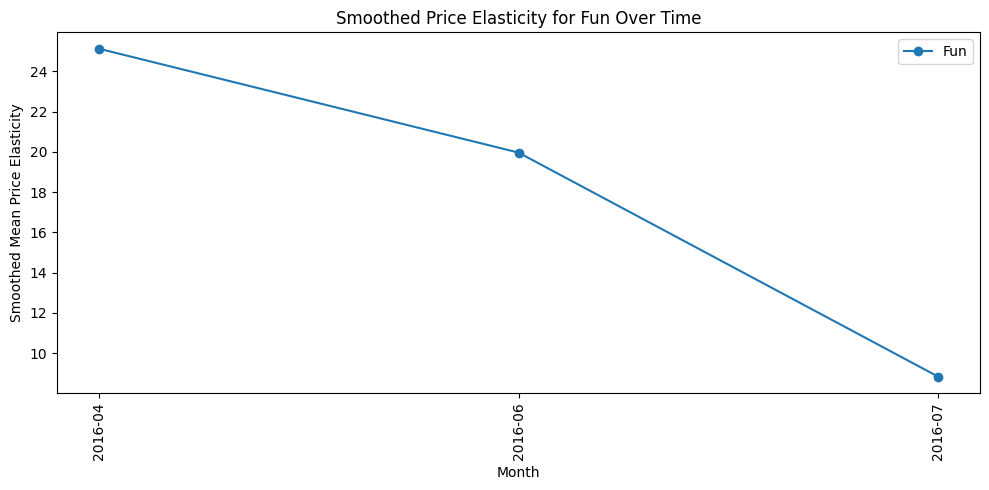

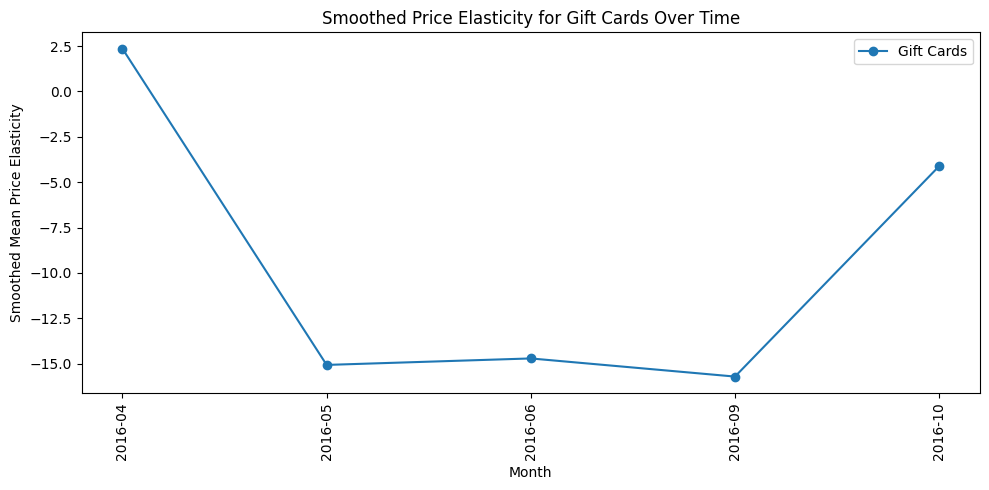

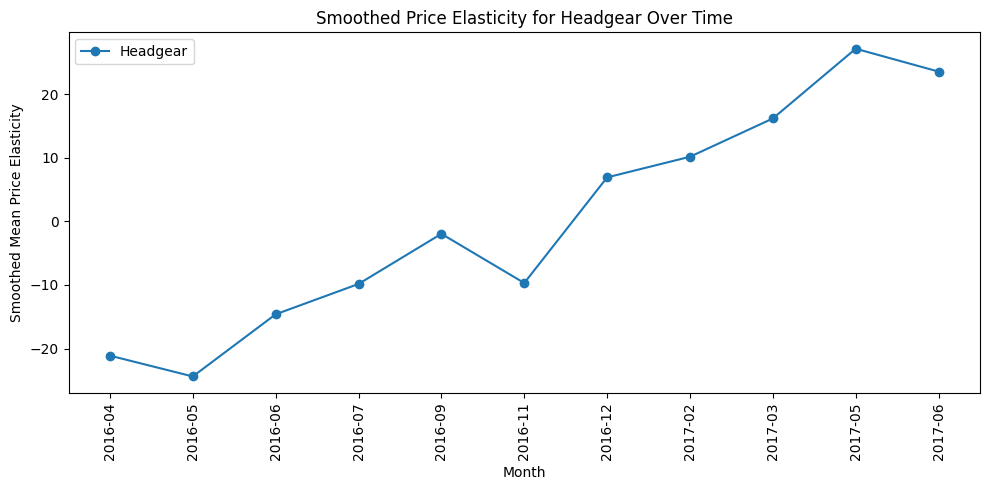

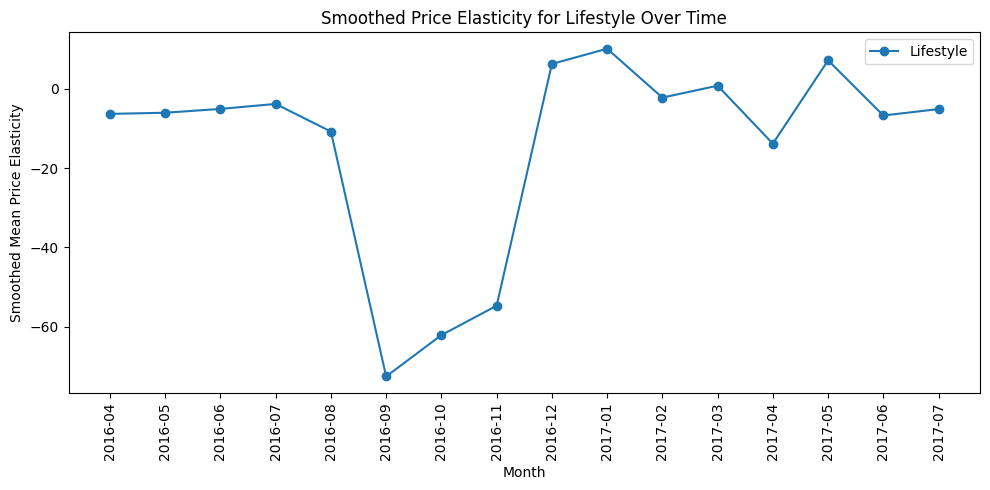

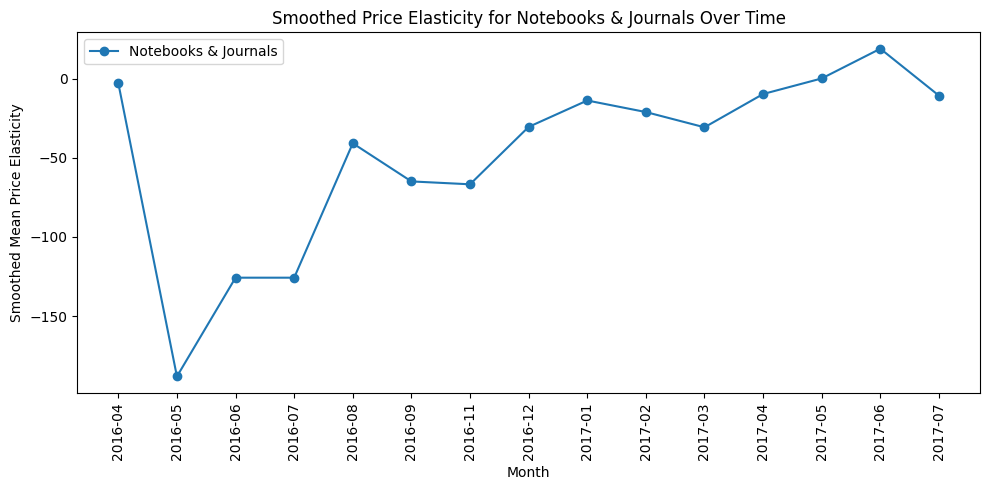

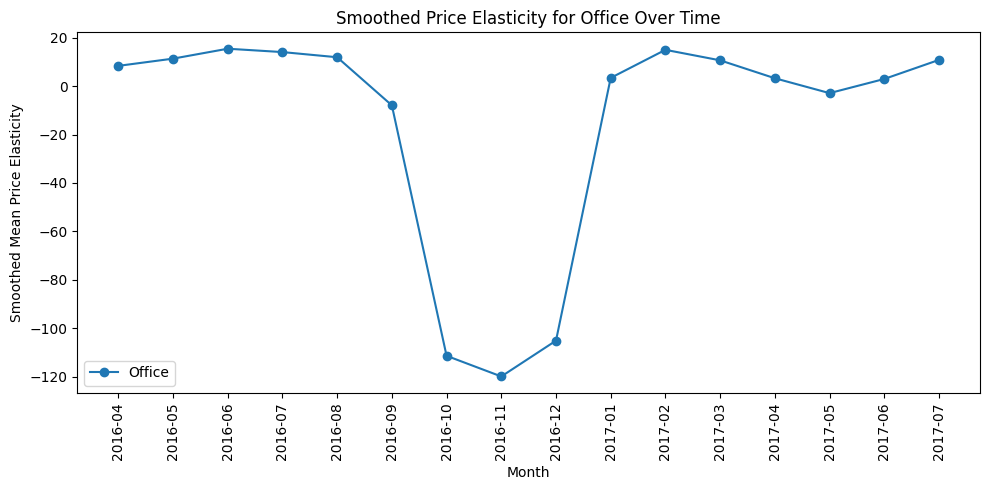

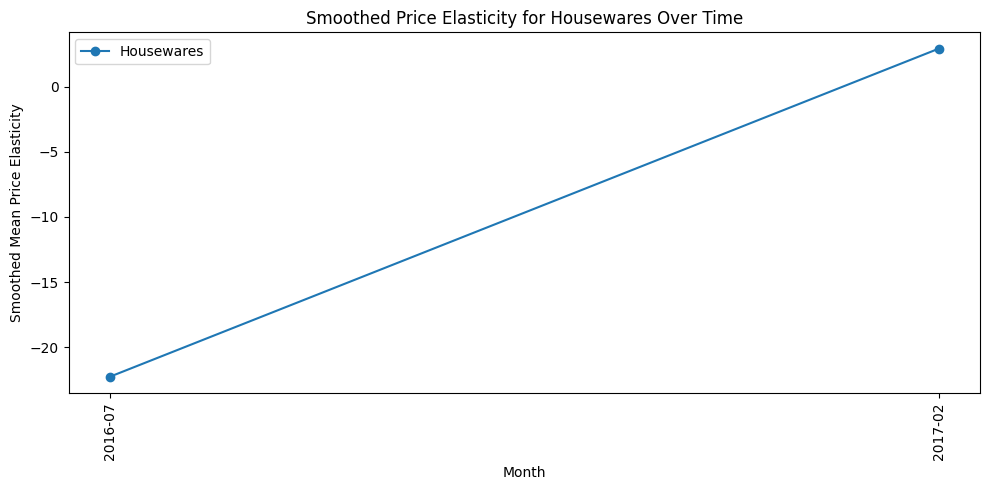

In [37]:
# Load the data
file_path = '/Users/valerielim/Documents/DSA3101-project/E-commerce-Performance-Analysis-and-Optimization/SubgroupB/price modelling/combined_price_elasticity_data.csv'
df = pd.read_csv(file_path)

# Drop any NaN values to ensure clean data
df_clean = df.dropna(subset=['mean_price_elasticity'])

# Apply smoothing using a rolling mean (moving average)
window_size = 3  # You can adjust the window size for more/less smoothing

# Loop through each product category and plot individually
for category in df_clean['product_category'].unique():
    category_data = df_clean[df_clean['product_category'] == category].copy()
    
    # Apply moving average to smooth the mean price elasticity
    category_data['smoothed_price_elasticity'] = category_data['mean_price_elasticity'].rolling(window=window_size, min_periods=1).mean()
    
    # Create a new figure for each product category
    plt.figure(figsize=(10, 5))
    
    # Plot the smoothed price elasticity for the category
    plt.plot(category_data['month'], category_data['smoothed_price_elasticity'], marker='o', label=category)
    
    # Add labels and title
    plt.xlabel('Month')
    plt.ylabel('Smoothed Mean Price Elasticity')
    plt.title(f'Smoothed Price Elasticity for {category} Over Time')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [31]:
# Accessories have rising price elasticity from March 2016 and peaked at July 2016 before decreasing trend.
# Apparel have generally decreasing price elasticity until March 2017 then sharp increase. 
# Bags have general decreasing trend.
# Drinkware decreasing steadily until March 2017 where there is sharp increase.
# Electronics general decreasing trend.
# Fun products stable until sharp increase from April 2017.
# Gift cards sharp decrease then stable.
# Headgear volatile 
# Housewares generally stable with downs and ups from November 2016 to April 2017.
# Lifestyle dip from July to November 2016 before returning to normal levels.
# Notebooks and Journals volatile 
# Office stable then sharp decrease from September to December 2016 before returning to normal levels.